In [1]:
from datetime import timedelta

import implicit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix, coo_matrix

from utils import train_test_split

In [2]:
pd.options.display.max_rows=200

In [3]:
df = pd.read_csv("./transactions_train.csv")
articles = pd.read_csv("./articles.csv")

df.t_dat = pd.to_datetime(df.t_dat)

In [4]:
last_date = df.t_dat.max()
week_distance = (last_date - df.t_dat).dt.days // 7
week_distance = week_distance.max() - week_distance

In [5]:
df = df.assign(week_id = week_distance)

In [6]:
week_item_dic = {}
week_user_dic = {}
for week_id, group in tqdm(df.groupby("week_id")):
    week_item_dic[week_id] = set(group.article_id)
    week_user_dic[week_id] = set(group.customer_id)

100%|██████████| 105/105 [00:09<00:00, 10.80it/s]


In [7]:
ordered_keys = sorted(week_item_dic.keys())

In [8]:
res = []
for key_idx, key in enumerate(ordered_keys[:-1]):
    cur_items = week_item_dic[key]
    cur_item_count = len(cur_items)

    next_item_pool = set()
    for next_idx in range(max(ordered_keys), key_idx, -1):
        next_items = week_item_dic[next_idx]
        next_item_pool |= next_items
        
        survived_item_count = len(cur_items & next_items)
        survived_item_ratio = survived_item_count / cur_item_count

        res.append([key, cur_item_count, next_idx, survived_item_count, survived_item_ratio])

In [9]:
cohort_df = pd.DataFrame(res, columns=["week", "sold_item_count", "next_week", "survivied_item_count", "survived_item_ratio"])

In [10]:
cohort_pivot = cohort_df.pivot(index="week", columns="next_week", values="survived_item_ratio")

In [11]:
cohort_pivot[::-1]

next_week,1,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,101,102,103,104
week,,,,,,,,,,,,,,,,,,,,,
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.749933
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.746565,0.710722
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.769144,0.722443,0.678597
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.768722,0.731378,0.690529,0.642471
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.779389,0.743855,0.703949,0.661833,0.616631
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.778000,0.751720,0.705010,0.659583,0.624936,0.576891
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.763828,0.744938,0.722028,0.673205,0.631067,0.594837,0.548871
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.779900,0.734248,0.711375,0.696331,0.651481,0.608234,0.572062,0.525467
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.806160,0.781394,0.734248,0.710456,0.688075,0.639517,0.595388,0.560064,0.515059


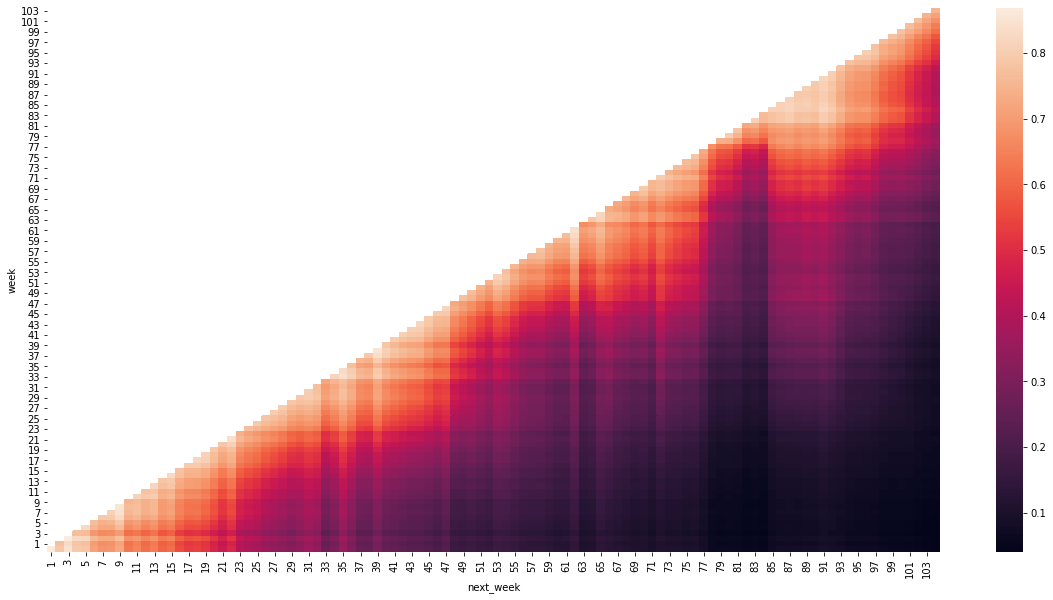

In [12]:
plt.figure(figsize=(20,10))
ax = sns.heatmap(cohort_pivot[::-1])

### 통계 지표 뽑기

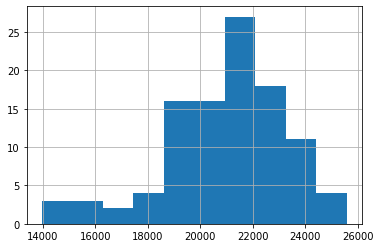

In [13]:
## 주차별 판매된 유니크 아이템 수 히스토그램
cohort_df[["week", "sold_item_count"]].drop_duplicates().sold_item_count.hist()
plt.show()

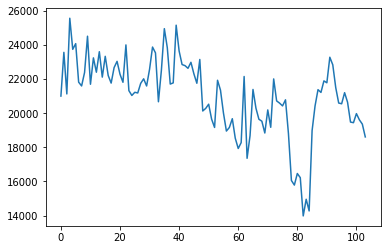

In [14]:
week_sold_item_count_df = cohort_df[["week", "sold_item_count"]].drop_duplicates()
plt.plot(week_sold_item_count_df.week, week_sold_item_count_df.sold_item_count)

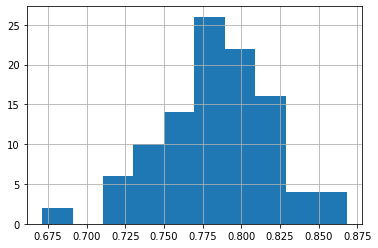

In [15]:
## 1주차 생존률 히스토그램
cohort_df.loc[cohort_df.next_week - cohort_df.week == 1, "survived_item_ratio"].hist()

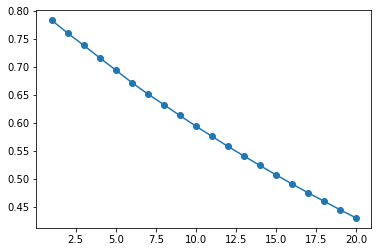

In [16]:
## 1주차 생존률 히스토그램
pd.Series({i:cohort_df.loc[cohort_df.next_week - cohort_df.week == i, "survived_item_ratio"].mean() for i in range(1, 21)}).plot(marker="o")
plt.show()